# RGB To Gocad Palette

Input: A point set file containing RGB values for each point
Output: A 256 color palette file + the point file with a texture coordinate column

This notebook loads a set of RGB values and performs K-means in RGB space to get the most representative colors.
See also https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py
### First, some imports and global variables

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# Fix random seed
np.random.seed(0)

# Set path to read / store files
# from pathlib import Path
path='D:\Data\Field\FOLD_CAQUERELLE\LiDAR3Dpoint clouds\\'
input_file='Leica3.ptx'
base_name = input_file.rsplit('.', 1)[0]

In [10]:
### Reading the input file

In [11]:
def read_leica_lidar( input_leica_ptx_file ) :
    leica_data = pd.read_csv(
        path + input_leica_ptx_file, delimiter = ' ', header=10,
        names=('X', 'Y', 'Z', 'Intensity', 'R', 'G', 'B' )
    )
    return leica_data

data = read_leica_lidar(input_file)

### Run the rgb clustering to form the color palette

In [12]:
scaler = StandardScaler()
std_data = scaler.fit_transform(data[['R','G','B']])
pca = PCA(n_components=2)
pca.fit( std_data )
scores_pca = pca.transform(std_data)


In [13]:
# kmeans = KMeans(n_clusters=16, random_state=0)  # Too slow
kmeans = MiniBatchKMeans( n_clusters=256, init='random', batch_size=1024)

# data['Texture'] = kmeans.fit_predict(data[['R','G','B']])
data['PC1'] = scores_pca[:,0]
data['PC2'] = scores_pca[:,1]
data['Texture'] = kmeans.fit_predict(data[['PC1','PC2']])
# data.plot('R', 'G', kind='scatter', c='Texture', cmap='viridis', marker='.')
# plt.show()

### Some visualization on a subset of points

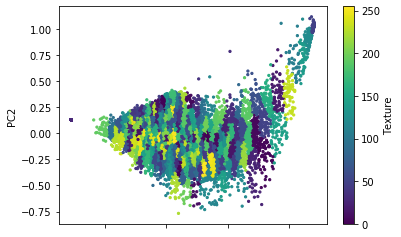

In [14]:
sample = shuffle(data[['PC1','PC2']], random_state=0, n_samples=20000)
sample['Texture'] = kmeans.predict(sample)
sample.plot('PC1', 'PC2', kind='scatter', c='Texture', cmap='viridis', marker='.')
plt.show()# data


# data.plot('PC1', 'PC2', kind='scatter', c='Texture', cmap='viridis', marker='.')



palette = kmeans.cluster_centers_

### Create the color map file in Gocad 2019 format

In [15]:
def write_palette_file( color_map ):
    file = open(path + base_name + '.xcmap', 'w+')
    file.write("""<?xml version="1.0" encoding="UTF-8" standalone="no" ?>
<Colormaps xmlns="http://pdgm.com/Gocad/ColormapEntity/2.8.0">
    <ColormapEntity>
""")
    file.write( f'<Name> {base_name} </Name>')
    file.write("""
        <Kind>linear</Kind>
        <Colors>
        """)
    color_index = 0
    for col in color_map :
        file.write( f'<Color index=" {color_index} " rgb="' +
                    f'{col[0]/255} {col[1]/255} {col[2]/255}"/>\n'
                    )
        color_index+=1
    file.write("""
            </Colors>
            </ColormapEntity>
        </Colormaps>
        """)

### Write the output files

In [16]:
data.to_csv(path + base_name + '.csv',
            sep = ' ',
            columns=['X','Y','Z','Intensity','Texture'],
            index=False)
write_palette_file(palette)


IndexError: index 2 is out of bounds for axis 0 with size 2